In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib as mpl
rng = np.random.default_rng()

In [3]:
#Note -- place your own MNIST files in the appropriate directory
train_data = np.loadtxt("./data/mnist/mnist_train.csv", delimiter=',')
test_data = np.loadtxt("./data/mnist/mnist_test.csv", delimiter=',')

In [4]:
train_imgs = train_data[:, 1:]
test_imgs = test_data[:, 1:]
train_labels = train_data[:, 0]
test_labels = test_data[:, 0]

In [3]:
def k_cap(input, cap_size):
    output = np.zeros_like(input)
    if len(input.shape) == 1:
        idx = np.argsort(input)[-cap_size:]
        output[idx] = 1
    else:
        idx = np.argsort(input, axis=-1)[:, -cap_size:]
        np.put_along_axis(output, idx, 1, axis=-1)
    return output

In [13]:
n_in = 784
n_neurons = 1000
cap_size = 100
sparsity = 0.8
n_rounds = 5
beta = 1e0

number_of_children = 3
children_adjacency_matrix_list = []

def generate_random_graph(n_neurons, sparsity):
    mask = np.zeros((n_neurons, n_neurons), dtype=bool)
    W = np.zeros((n_neurons, n_neurons))

    mask = (rng.random((n_neurons, n_neurons)) < sparsity) & np.logical_not(np.eye(n_neurons, dtype=bool))
    W = np.ones((n_neurons, n_neurons)) * mask
    W /= W.sum(axis=0)
    return W.copy()

def merge_assemblies(children_adjacency_matrix_list, n_neurons, sparsity):
    assert children_adjacency_matrix_list[0].shape == children_adjacency_matrix_list[0].shape
    number_of_children_assemblies = len(children_adjacency_matrix_list)
    number_of_nodes_per_child_assembly = children_adjacency_matrix_list[0].shape[0]
    merged_dimensions = number_of_nodes_per_child_assembly*(number_of_children_assemblies+1)
    merged_adjacency_matrix = np.zeros((merged_dimensions, merged_dimensions))
    for index in range(number_of_children_assemblies+1):
        if index == 0:
            current_assembly = generate_random_graph(n_neurons, sparsity)
            merged_adjacency_matrix[:number_of_nodes_per_child_assembly, :number_of_nodes_per_child_assembly] = current_assembly.copy()
        else:
            print(number_of_nodes_per_child_assembly*(index+1))
            print(number_of_nodes_per_child_assembly*index)
            merged_adjacency_matrix[number_of_nodes_per_child_assembly*index:number_of_nodes_per_child_assembly*(index+1), :number_of_nodes_per_child_assembly] = generate_random_graph(n_neurons, sparsity)
            merged_adjacency_matrix[:number_of_nodes_per_child_assembly, number_of_nodes_per_child_assembly*index:number_of_nodes_per_child_assembly*(index+1)] = generate_random_graph(n_neurons, sparsity)
            merged_adjacency_matrix[number_of_nodes_per_child_assembly*index:number_of_nodes_per_child_assembly*(index+1), number_of_nodes_per_child_assembly*index:number_of_nodes_per_child_assembly*(index+1)] = children_adjacency_matrix_list[index-1].copy()
    return merged_adjacency_matrix.copy()

def generate_n_assemblies(n):
    children_adjacency_matrix_list = []
    for i in range(n):
        current_w = generate_random_graph(n_neurons, sparsity)
        children_adjacency_matrix_list.append(current_w)
    return children_adjacency_matrix_list
        
children_assemblies = generate_n_assemblies(3)
merged_assemblies = merge_assemblies(children_assemblies, n_neurons, sparsity)
print(merged_assemblies)
print(merged_assemblies.shape)


2000
1000
3000
2000
4000
3000
[[0.         0.         0.00124378 ... 0.00125786 0.00126743 0.00127065]
 [0.00122249 0.         0.00124378 ... 0.00125786 0.         0.00127065]
 [0.00122249 0.         0.         ... 0.00125786 0.00126743 0.        ]
 ...
 [0.         0.         0.00129366 ... 0.         0.00125471 0.        ]
 [0.00123609 0.00126582 0.00129366 ... 0.00126904 0.         0.00126743]
 [0.00123609 0.         0.00129366 ... 0.         0.         0.        ]]


In [39]:
merged_assemblies[2000:3000, 0:1000] = children_assemblies[0]
merged_assemblies.shape

(4000, 4000)

In [ ]:

mask_a = np.zeros((n_in, n_neurons), dtype=bool)
A = np.zeros((n_in, n_neurons))

mask_a = rng.random((n_in, n_neurons)) < sparsity
A = np.ones((n_in, n_neurons)) * mask_a
A /= A.sum(axis=0)

In [7]:
from scipy.signal import convolve
n_examples = 1000
examples = np.zeros((10, n_examples, 784))
for i in range(10):
    examples[i] = k_cap(convolve(train_imgs[train_labels == i][:n_examples].reshape(-1, 28, 28), np.ones((1, 3, 3)), mode='same').reshape(-1, 28 * 28), cap_size)

In [8]:
W = np.ones_like(W) * mask
A = np.ones_like(A) * mask_a
W /= W.sum(axis=0, keepdims=True)
A /= A.sum(axis=0, keepdims=True)
bias = np.zeros(n_neurons)
b = -1
for i in range(10):
    activations = np.zeros((n_rounds, n_neurons))
    act_h = np.zeros(n_neurons)
    for j in range(n_rounds):
        input = examples[i, j]
        act_h_new = k_cap(act_h @ W + input @ A + bias, cap_size)
        activations[j] = act_h_new.copy()
        A[(input > 0)[:, np.newaxis] & (act_h_new > 0)[np.newaxis, :]] *= 1 + beta
        W[(act_h > 0)[:, np.newaxis] & (act_h_new > 0)[np.newaxis, :]] *= 1 + beta
        act_h = act_h_new
    bias[act_h > 0] += b
    A /= A.sum(axis=0, keepdims=True)
    W /= W.sum(axis=0, keepdims=True)

In [9]:
outputs = np.zeros((10, n_rounds+1, n_examples, n_neurons))
for i in np.arange(10):
    for j in range(n_rounds):
        outputs[i, j+1] = k_cap(outputs[i, j] @ W + examples[i] @ A, cap_size)

In [10]:
idx = np.full(n_neurons, -1, dtype=int)
act = outputs[:, -1].sum(axis=1)
for i, j in enumerate(range(10)):
    idx[i*cap_size:(i+1)*cap_size] = act[j].argsort()[-cap_size:][::-1]
    act[:, idx[i*cap_size:(i+1)*cap_size]] = -1
r = np.arange(n_neurons)
r[idx[idx > -1]] = -1
idx[(i+1)*cap_size:] = np.unique(r)[1:]

In [13]:
fig, axes = plt.subplots(10, n_rounds, figsize=(10, 2 * 10), sharex=True, sharey=True)
for ax, output in zip(axes, outputs):
    for i in range(n_rounds):
        ax[i].imshow((output[i+1] > 0)[:, idx])
        ax[i].set_axis_off()
fig.text(0.5, 0.04, 'Neurons', ha='center', va='center')
fig.text(0.04, 0.5, 'Samples', ha='center', va='center', rotation='vertical')

<IPython.core.display.Javascript object>

Text(0.04, 0.5, 'Samples')

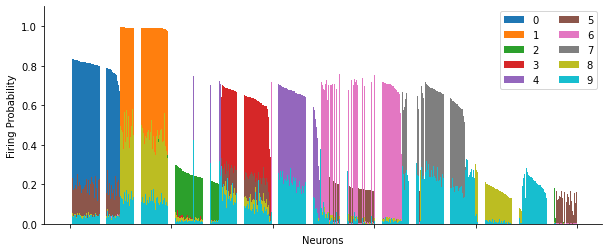

In [17]:
fig, ax = plt.subplots(figsize=(10, 4))
for i in range(10):
    ax.bar(np.arange(n_neurons), outputs[i, -1].mean(axis=0)[idx], label=i)
ax.legend(loc='upper right', ncol=2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim([0, 1.1])
ax.set_xticklabels([])
ax.set_xlabel('Neurons')
ax.set_ylabel('Firing Probability')
plt.show()

In [15]:
c = np.zeros((10, n_neurons))
for i in range(10):
    c[i, outputs[i, 1].sum(axis=0).argsort()[-cap_size:]] = 1
#     c[i, idx[i*cap_size:(i+1)*cap_size]] = 1
predictions = (outputs[:, 1] @ c.T).argmax(axis=-1)
acc = (predictions == np.arange(10)[:, np.newaxis]).sum(axis=-1) / n_examples

In [16]:
acc

array([0.86 , 0.98 , 0.412, 0.664, 0.764, 0.391, 0.727, 0.773, 0.454,
       0.605])

In [17]:
fig, axes = plt.subplots(1, 10, figsize=(10, 2))
for i in range(10):
    axes[i].imshow((A * c[i][np.newaxis, :]).sum(axis=1).reshape(28, 28))
    axes[i].set_axis_off()
fig.tight_layout()

<IPython.core.display.Javascript object>

In [18]:
n_in = 784
n_neurons = 2000
cap_size = 200
sparsity = 0.1
n_rounds = 5
beta = 1e0
mask = np.zeros((n_neurons, n_neurons), dtype=bool)
W = np.zeros((n_neurons, n_neurons))
mask_a = np.zeros((n_in, n_neurons), dtype=bool)
A = np.zeros((n_in, n_neurons))
mask = (rng.random((n_neurons, n_neurons)) < sparsity) & np.logical_not(np.eye(n_neurons, dtype=bool))
W = np.ones((n_neurons, n_neurons)) * mask
W /= W.sum(axis=0)
mask_a = rng.random((n_in, n_neurons)) < sparsity
A = np.ones((n_in, n_neurons)) * mask_a
A /= A.sum(axis=0)

In [19]:
n_trials = 20
accs = np.zeros((9, n_trials))
for k in range(n_trials):
    W = np.ones_like(W) * mask
    A = np.ones_like(A) * mask_a
    W /= W.sum(axis=0, keepdims=True)
    A /= A.sum(axis=0, keepdims=True)
    bias = np.zeros(n_neurons)
    b = -1
    for i in range(10):
        activations = np.zeros((n_rounds, n_neurons))
        act_h = np.zeros(n_neurons)
        for j in range(n_rounds):
            input = examples[i, rng.choice(n_examples)]
            act_h_new = k_cap(act_h @ W + input @ A + bias, cap_size)
            activations[j] = act_h_new.copy()
            A[(input > 0)[:, np.newaxis] & (act_h_new > 0)[np.newaxis, :]] *= 1 + beta
            W[(act_h > 0)[:, np.newaxis] & (act_h_new > 0)[np.newaxis, :]] *= 1 + beta
            act_h = act_h_new
        bias[act_h > 0] += b
        A /= A.sum(axis=0, keepdims=True)
        W /= W.sum(axis=0, keepdims=True)
        if i == 0:
            continue
        outputs = np.zeros((i+1, n_examples, n_neurons))
        c = np.zeros((10, n_neurons))
        for j in range(i+1):
            outputs[j] = k_cap(examples[j] @ A, cap_size)
            c[j, outputs[j].sum(axis=0).argsort()[-cap_size:]] = 1
        predictions = (outputs @ c.T).argmax(axis=-1)
        accs[i-1, k] = (predictions == np.arange(i+1)[:, np.newaxis]).sum() / (n_examples * (i+1))        

In [22]:
fig, ax = plt.subplots(figsize=(5, 4))
# ax.fill_between(np.arange(2, 11), 100 * accs.mean(axis=-1) - 100*accs.std(axis=-1), 100 * accs.mean(axis=-1) + 100*accs.std(axis=-1), alpha=0.5)
ax.fill_between(np.arange(2, 11), 100 * accs.min(axis=-1), 100 * accs.max(axis=-1), alpha=0.5)
ax.plot(np.arange(2, 11), 100 * accs.mean(axis=-1))
ax.set_xlabel(r'Number of Classes')
ax.set_ylabel('Accuracy (%)')
ax.set_ylim([50, 100])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.tight_layout()
plt.show()

<IPython.core.display.Javascript object>